In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from matplotlib import cm
from run import order

In [2]:
size = (7, 3)
start = 0
p = 1

In [3]:
# parser = argparse.ArgumentParser(
#     description="Plot the results of the chimera experiments")
# parser.add_argument(
#     "f", metavar="f", type=str, nargs=1,
#     help="The file of which we're making a plot."
# )
# file = parser.parse_args().f[0]

In [4]:
! rsync --progress "bluemoon-user1.uvm.edu:thesis/data/high_res/0.900-0.900.pkl" "../../data/high_res/0.900-0.900.pkl"


0.900-0.900.pkl
^C
rsync error: received SIGINT, SIGTERM, or SIGHUP (code 20) at /BuildRoot/Library/Caches/com.apple.xbs/Sources/rsync/rsync-52.200.1/rsync/rsync.c(244) [generator=2.6.9]


In [21]:
file = "../../data/0.851-0.800.pkl"

In [22]:
def similar(matrix, cortices, w=2):
    sim = np.empty([matrix.shape[0], matrix.shape[1] + w*(len(cortices) - 1)])
    sim[:] = np.nan
    for i, cortex in enumerate(cortices):
        sim[:, (cortex[0] + w*i):(cortex[1] + w*i)
            ] = matrix[:, cortex[0]:cortex[1]]
    return sim

In [23]:
current_cmap = cm.get_cmap()
current_cmap.set_bad(color='black')

In [24]:
metadata = pd.read_excel("../connectomes/mouse_meta.xlsx", sheet_name=None)
mtdt = metadata["Voxel Count_295 Structures"]
del(metadata)
mtdt = mtdt.loc[mtdt["Represented in Linear Model Matrix"] == "Yes"]
columns = []
cortices = [[0, 0]]
regions = mtdt["Major Region"].unique()
for region in regions:
    i = [columns.append(acronym.replace(" ", "")) for acronym in
         mtdt.loc[mtdt["Major Region"] == region, "Acronym"].values]
    cortices.append([cortices[-1][-1], cortices[-1][-1] + len(i)])
cortices.remove([0, 0])
del(mtdt)

In [25]:
with open(file, "rb") as f:
    [(b, i0, x_rev, λ, θ, μ, s, x_rest, α, n1, β, n2, G1, G2),
     sol, phase, χ, m] = pickle.load(f)

In [26]:
N = phase.shape[0]
plot_range = slice(int(start*N), int((start + p)*N))
phase = phase[plot_range]

In [27]:
y = sol.y.T.reshape(N, 3, -1)[int(start*N):int((start + p)*N), :, :]
t = sol.t
del(sol)

In [28]:
dot = y[:, 1, :] - (y[:, 0, :])**3 + b*(y[:, 0, :]**2) + i0 - y[:, 2, :]

In [29]:
dot.shape

(400000, 213)

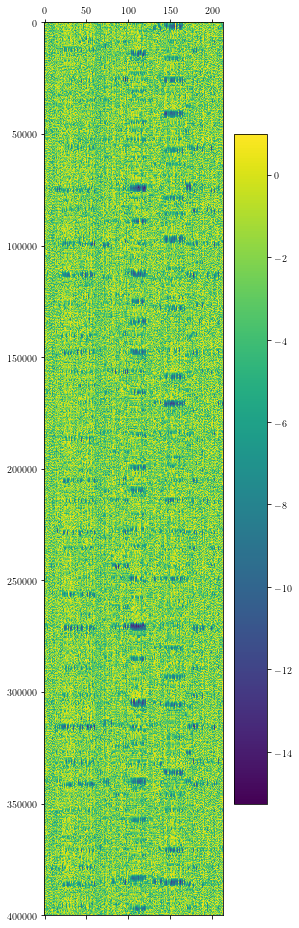

In [31]:
plt.matshow(y[:, 1, :], aspect="auto")
plt.colorbar()

In [13]:
title = f"$\\alpha$: {α:.03f}, $\\beta$: {β:.03f}, $\\chi$: {χ*7:.04f}, $m$: {m*12:.04f}"

In [11]:
means = np.zeros([len(cortices), phase.shape[0]])
sums = np.copy(means)

In [12]:
for i, cortex in enumerate(cortices):
    means[i] = np.mean(y[:, 0, cortex[0]:cortex[1]], axis=-1)
    sums[i] = np.sum(y[:, 0, cortex[0]:cortex[1]], axis=-1)

In [13]:
ρ_bar = np.mean(np.array([order(phase[:, low:high])
                          for [low, high] in cortices]),
                axis=0)

sigma = np.sum(np.array([(order(phase[:, low:high]) - ρ_bar)**2
                         for [low, high] in cortices]), axis=0)/len(cortices)

In [14]:
# MEANS
for i, mn in enumerate(means):
    plt.plot(t, mn + 2.5*i, lw=0.15, color="k")

plt.xlim([0, t.max()])
plt.title(title)
plt.xlabel("$t$")
plt.ylabel(r"$\expval{x_{j}}_{j \in C}$")

plt.yticks([2.5*i for i in range(len(regions))], regions)

fig = plt.gcf()
fig.set_size_inches(*size, forward=True)
fig.savefig(f"../../final/figure/means-{α:.03f}-{β:.03f}.png", dpi=700,
            bbox_inches="tight", format="png")
plt.cla()
plt.clf()

<Figure size 504x216 with 0 Axes>

In [15]:
# OVERHEAD
plt.imshow(similar(phase, cortices, w=1).T, aspect="auto",
           origin="lower", interpolation="none")
[i.set_linewidth(0.01) for i in plt.gca().spines.values()]
plt.xlim([0, phase.shape[0]])
plt.yticks([cortex[0] + (cortex[1] - cortex[0])/2 + i for i, cortex in enumerate(cortices)], regions)
plt.title(title)
plt.colorbar()
fig = plt.gcf()
fig.set_size_inches(*size, forward=True)
plt.savefig(f"../../final/figure/overhead-{α:.03f}-{β:.03f}.png",
            dpi=500, bbox_inches="tight", format="png")
plt.cla()
plt.clf()

<Figure size 504x216 with 0 Axes>

In [ ]:
# ORDER
plt.plot(order(phase))
plt.xlim([0, phase.shape[0]])
plt.ylim([-0.025, 1.025])
plt.xlabel("time")
plt.ylabel("rho")
plt.title(title)
fig = plt.gcf()
fig.set_size_inches(*size, forward=True)
plt.savefig(f"../figure/order-{α:.03f}-{β:.03f}.png", dpi=500,
            bbox_inches="tight", format="png")
plt.cla()
plt.clf()


# SIGMA_I
for cortex in cortices:
    [low, high] = cortex
    plt.plot(((order(phase[:, low:high]) - ρ_bar)**2),
             label=f"{low + 1}-{high}", lw=0.05)
plt.xlim([0, phase.shape[0]])
plt.ylim([-0.05, 0.62])
plt.xlabel("time")
plt.ylabel("(rho - rho bar)**2")
plt.legend(bbox_to_anchor=(1, 1))
plt.title(title)
fig = plt.gcf()
fig.set_size_inches(*size, forward=True)
plt.savefig(f"../figure/by_cortex_variance-{α:.03f}-{β:.03f}.png",
            dpi=500, bbox_inches="tight", format="png")
plt.cla()
plt.clf()


# SIGMA
plt.plot(sigma)
plt.xlim([0, phase.shape[0]])
plt.ylim([-0.01, 0.15])
plt.xlabel("time")
plt.ylabel("sigma(chi(t))")
plt.title(title)
fig = plt.gcf()
fig.set_size_inches(*size, forward=True)
plt.savefig(f"../figure/sigma-{α:.03f}-{β:.03f}.png", dpi=500,
            bbox_inches="tight", format="png")
plt.cla()
plt.clf()


xticks = [cortex[1] + 2*i + 1 for i, cortex in enumerate(cortices)][:-1]


fig, [means_ax,
      overhead_ax,
      order_ax,
      variance_ax,
      by_cortex_variance_ax] = plt.subplots(5, 1, sharex=True, squeeze=True)

means_ax.set_title(title)

for i, mn in enumerate(means):
    means_ax.plot(mn + 2.5*i, lw=0.07, color="k")

means_ax.tick_params(axis="y",
                     left=False)
means_ax.set_yticklabels(["" for i in means_ax.get_yticks()])


[i.set_linewidth(0.01) for i in overhead_ax.spines.values()]
overhead_ax.set_xlim([0, phase.shape[0]])

overhead_ax.matshow(similar(phase, cortices, 2).T,
                    aspect="auto", origin="lower", interpolation="none")
overhead_ax.set_yticks(xticks)
overhead_ax.set_yticklabels(["" for i in xticks])
overhead_ax.tick_params(axis="y",
                        width=0.2)
overhead_ax.tick_params(axis="x",
                        top=False)


order_ax.plot(order(phase), lw=0.1)
order_ax.set_ylim([-0.025, 1.025])


variance_ax.plot(sigma, lw=0.1)
variance_ax.set_ylim([-0.01, 0.15])


for cortex in cortices:
    [low, high] = cortex
    by_cortex_variance_ax.plot(((order(phase[:, low:high]) - ρ_bar)**2),
                               label=f"{low + 1}-{high}", lw=0.07)
by_cortex_variance_ax.set_ylim([-0.05, 0.62])

fig.set_size_inches(*size, forward=True)
fig.savefig(f"../figure/all-{α:.03f}-{β:.03f}.png", dpi=700,
            bbox_inches="tight", format="png")
plt.cla()
plt.clf()